In [14]:
import scipy.io as sio
import numpy as np


In [15]:
EcogMat = sio.loadmat('C:/Users/35MAJN/Desktop/Ipsilateral/2018-04-29_(S1)/ECoG.mat')
MotionMat = sio.loadmat('C:/Users/35MAJN/Desktop/Ipsilateral/2018-04-29_(S1)/Motion.mat')

In [11]:
print(MotionMat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Fsm', 'Motion_time', 'Right_Wrist'])


In [16]:
ECoG = EcogMat['ECoG']
ECoG_time = EcogMat['ECoG_time']
Fs = EcogMat['Fs']
Fsm = MotionMat['Fsm']
Motion_time = MotionMat['Motion_time']
Right_Wrist = MotionMat['Right_Wrist']

In [16]:
print('ECoG:', ECoG.shape)
print('ECoG_time:', ECoG_time.shape)
print('Motion_time', Motion_time.shape)
print('Right_Wrist', Right_Wrist.shape)
print('Fs: ', Fs)
print('Fsm: ', Fsm)

ECoG: (920498, 64)
ECoG_time: (920498, 1)
Motion_time (46227, 1)
Right_Wrist (46227, 3)
Fs:  [[1000]]
Fsm:  [[50]]


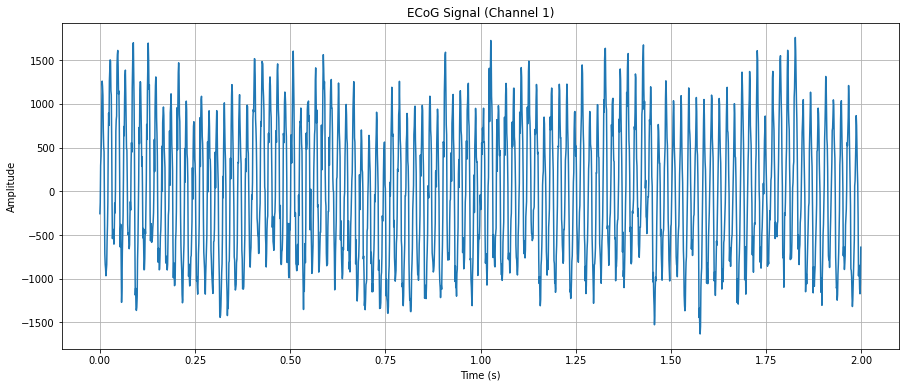

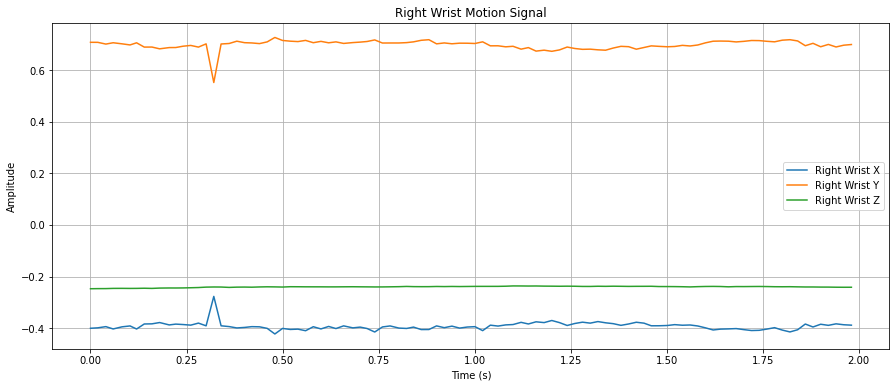

In [25]:
import scipy.io
import matplotlib.pyplot as plt


# Plot ECoG signal
plt.figure(figsize=(15, 6))
plt.plot(ECoG_time[:2000], ECoG[:2000, 0])  # Plotting the first 1000 samples of the first ECoG channel
plt.title('ECoG Signal (Channel 1)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Plot Motion signals (assuming Right_Wrist is 3D, with each row as a time point and each column as an axis)
plt.figure(figsize=(15, 6))
plt.plot(Motion_time[:100], Right_Wrist[:100, 0], label='Right Wrist X')
plt.plot(Motion_time[:100], Right_Wrist[:100, 1], label='Right Wrist Y')
plt.plot(Motion_time[:100], Right_Wrist[:100, 2], label='Right Wrist Z')
plt.title('Right Wrist Motion Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


# Common Average 

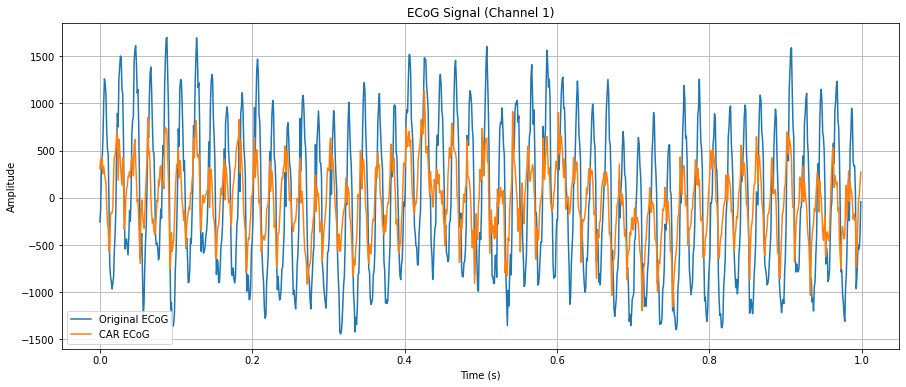

In [8]:
# Compute the Common Average Reference (CAR)
mean_signal = np.mean(ECoG, axis=1, keepdims=True)
ECoG_car = ECoG - mean_signal

# Plot the original and CAR ECoG signal for the first 1000 samples of the first channel
plt.figure(figsize=(15, 6))
plt.plot(ECoG_time[:1000], ECoG[:1000, 0], label='Original ECoG')
plt.plot(ECoG_time[:1000], ECoG_car[:1000, 0], label='CAR ECoG')
plt.title('ECoG Signal (Channel 1)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

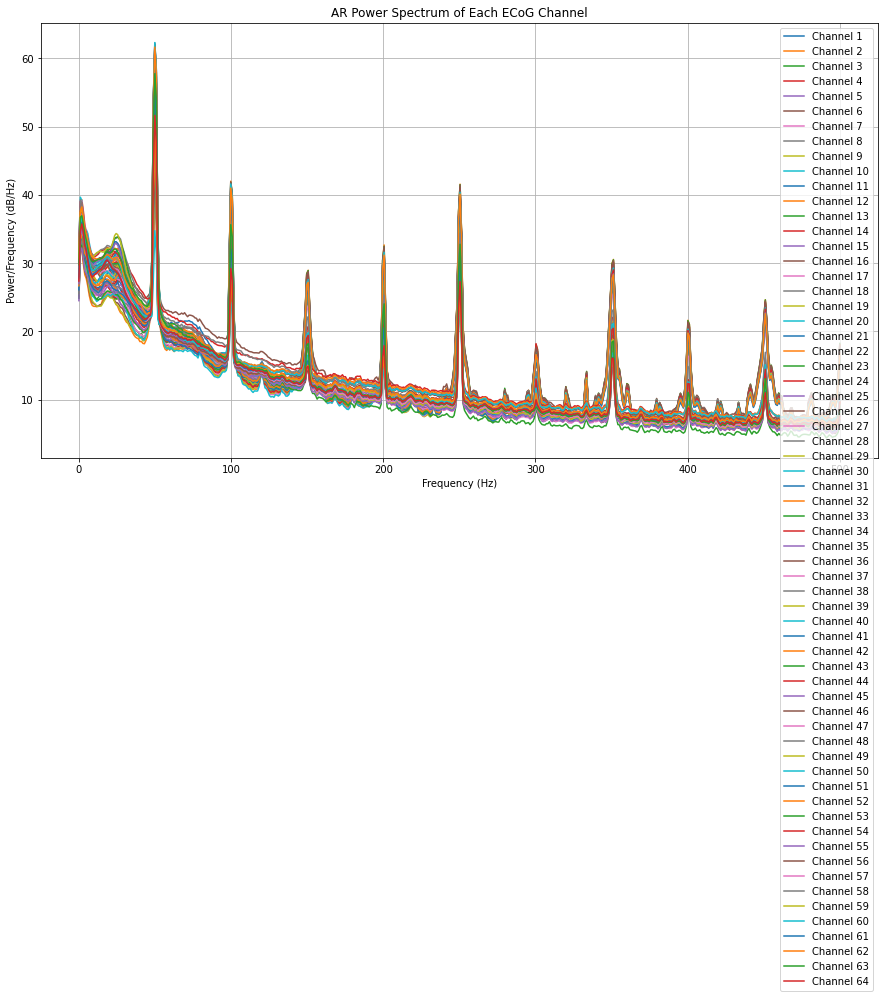

In [27]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from scipy.signal import welch


# Extract the data
ECoG = EcogMat['ECoG']
Fs = EcogMat['Fs'].item()  # Assuming Fs is a scalar

# Define the order of the AR model
order = 20

# Compute the AR power spectrum for each channel
frequencies = np.linspace(0, Fs/2, 512)
psd_all_channels = []

for channel in range(ECoG.shape[1]):
    model = AutoReg(ECoG[:, channel], lags=order).fit()
    ar_params = model.params[1:]
    noise_variance = model.sigma2

    # Compute the power spectrum using the AR parameters
    ar_coeffs = np.zeros(order + 1)
    ar_coeffs[0] = 1
    ar_coeffs[1:] = -ar_params
    _, psd = welch(ECoG[:, channel], fs=Fs, window='hann', nperseg=1024, noverlap=512, nfft=1024, return_onesided=True, scaling='density')
    psd_all_channels.append(psd)

psd_all_channels = np.array(psd_all_channels)

# Plot the AR power spectrum for each channel
plt.figure(figsize=(15, 8))
for channel in range(ECoG.shape[1]):
    plt.plot(frequencies, 10 * np.log10(psd_all_channels[channel][:len(frequencies)]), label=f'Channel {channel+1}')
plt.title('AR Power Spectrum of Each ECoG Channel')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


c:\Users\35MAJN\.conda\envs\Jobmetric\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\35MAJN\.conda\envs\Jobmetric\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


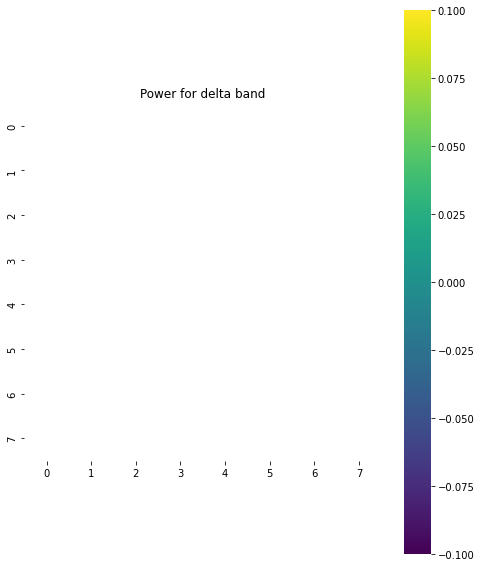

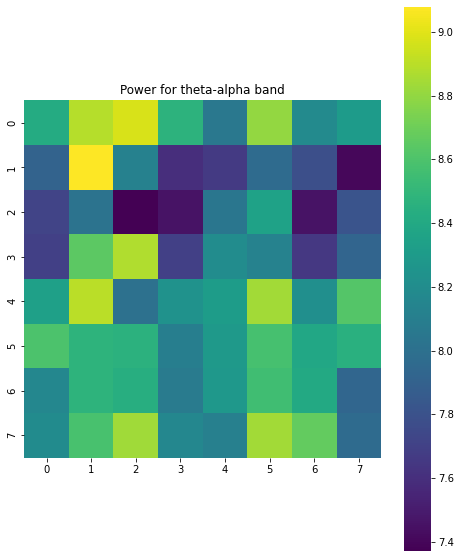

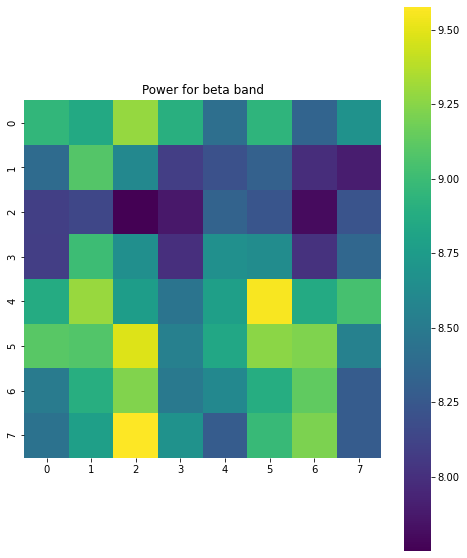

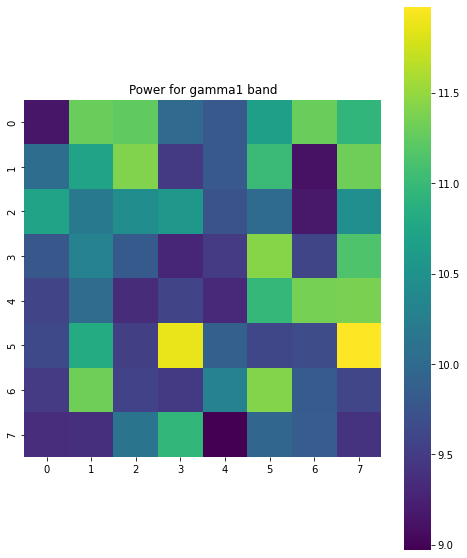

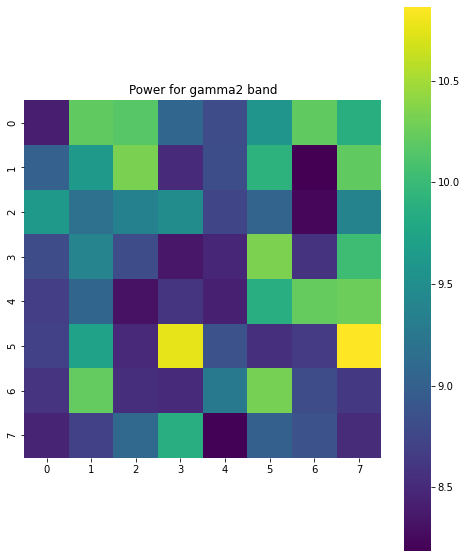

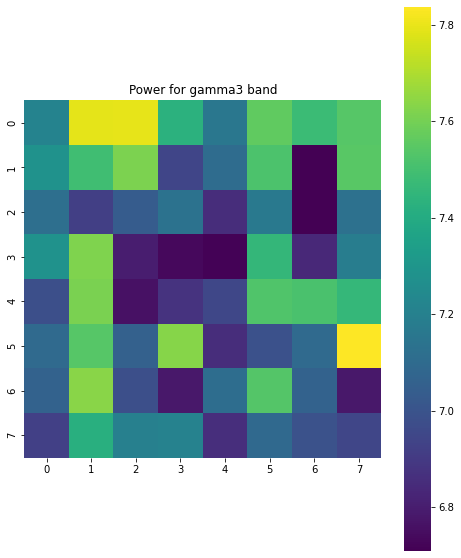

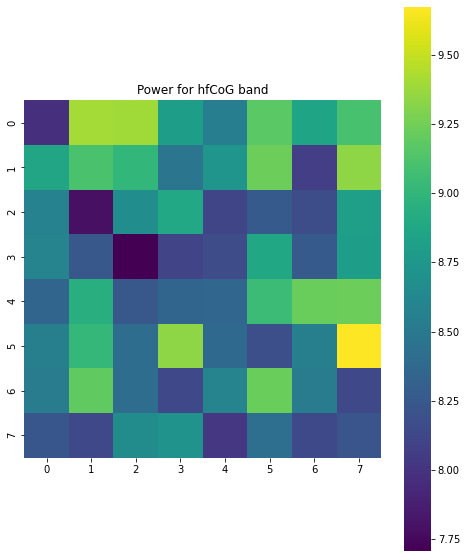

In [19]:

# Bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Filter and calculate power for each band using FFT
channel_powers = {band: [] for band in bands}
for band, (low_freq, high_freq) in bands.items():
    for i in range(ECoG_car.shape[1]):
        filtered_data = bandpass_filter(ECoG_car[:, i], low_freq, high_freq, Fs_ECoG)
        f, Pxx = welch(filtered_data, Fs_ECoG, nperseg=1024)
        band_power = np.trapz(Pxx[(f >= low_freq) & (f <= high_freq)], f[(f >= low_freq) & (f <= high_freq)])
        log_power = np.log(band_power)
        channel_powers[band].append(log_power)

# Convert to array
for band in channel_powers:
    channel_powers[band] = np.array(channel_powers[band])

# Plotting power on the topology
def plot_topology(data, title):
    fig, ax = plt.subplots(figsize=(8, 10))
    sns.heatmap(data.reshape(8, 8), ax=ax, cmap='viridis', cbar=True, square=True)
    ax.set_title(title)
    plt.show()

for band in channel_powers:
    plot_topology(channel_powers[band], f'Power for {band} band')